In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [26]:
data=pd.read_csv('simulation/simulation_arm_balance.csv')
data=data.rename({'t': 'Distance', 'prec': 'Accuracy','type':'Type'}, axis='columns')

In [27]:
data.describe(include='all')

,ytrue,ypred,method,alf,Type,Distance,Accuracy
count,2520000.0,2.520000e+06,2520000,2.520000e+06,2016000,2.520000e+06,2520000
unique,NaN,NaN,7,NaN,4,NaN,2
top,NaN,NaN,LDAS,NaN,hard,NaN,True
freq,NaN,NaN,2016000,NaN,504000,NaN,2211428
mean,0.5,4.987873e-01,NaN,-1.898667e-01,NaN,1.000000e+00,NaN
std,0.5,4.999986e-01,NaN,4.053507e-01,NaN,6.055302e-01,NaN
min,0.0,0.000000e+00,NaN,-1.000000e+00,NaN,0.000000e+00,NaN
25%,0.0,0.000000e+00,NaN,1.000000e-03,NaN,5.000000e-01,NaN
50%,0.5,0.000000e+00,NaN,5.000000e-03,NaN,1.000000e+00,NaN
75%,1.0,1.000000e+00,NaN,1.000000e-02,NaN,1.500000e+00,NaN


In [69]:
#datas=data[data.method=='LDAS']
datas=data.query("method=='LDAS'")

In [29]:
datas.head(10)

,ytrue,ypred,method,alf,Type,Distance,Accuracy
0,0,0,LDAS,0.05,hard,0.0,True
1,1,0,LDAS,0.05,hard,0.0,False
2,0,1,LDAS,0.05,hard,0.0,False
3,1,1,LDAS,0.05,hard,0.0,True
4,0,0,LDAS,0.05,hard,0.0,True
5,1,0,LDAS,0.05,hard,0.0,False
6,0,1,LDAS,0.05,hard,0.0,False
7,1,1,LDAS,0.05,hard,0.0,True
8,0,0,LDAS,0.05,hard,0.0,True
9,1,0,LDAS,0.05,hard,0.0,False


In [30]:
datas['Alpha']='alpha='+datas.alf.astype('str')

D:\Anoconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


in order to make alf recognized as factor by hue in seaborn, convert alf into string that unablt to be interpreted as numric

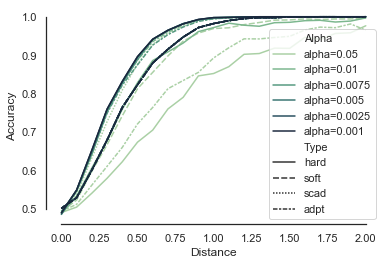

In [31]:
sns.set(style="white")
sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",style='Type',
             palette="ch:r=-.5,l=.75",
             data=datas,ci=None)
sns.despine(trim=True)

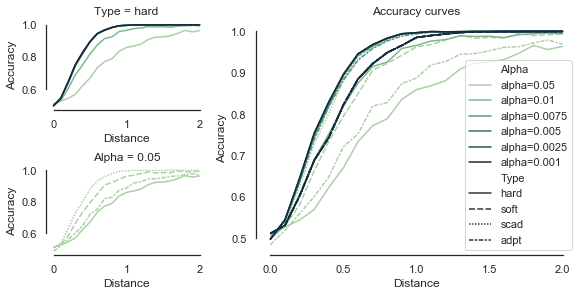

In [16]:
fig3 = plt.figure(constrained_layout=True,figsize=[8,4])
gs = fig3.add_gridspec(2, 3)
f3_ax1 = fig3.add_subplot(gs[:,1:])
sns.set(style="white")
sns_plot=sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",style='Type',
             palette="ch:r=-.5,l=.75",
             data=datas,ci=None)
sns.despine(trim=True)
sns_plot.set_title('Accuracy curves')
#sns_plot.set(xlabel='Distance', ylabel='Accuracy')

f3_ax2 = fig3.add_subplot(gs[0,0])
sns.set(style="white")
sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",
             palette="ch:r=-.5,l=.75",
             data=datas.query("Type=='hard'"),ci=None,
            legend=None).set_title('Type = hard')
sns.despine(trim=True)

f3_ax3 = fig3.add_subplot(gs[1,0])
sns.set(style="white")
sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",style='Type',
             palette="ch:r=-.5,l=.75",
             data=datas.query("alf==0.05"),ci=None,
            legend=None).set_title('Alpha = 0.05')  
sns.despine(trim=True)

In [17]:
fig = sns_plot.get_figure()
fig.savefig('arm_sim.eps', format='eps', dpi=100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


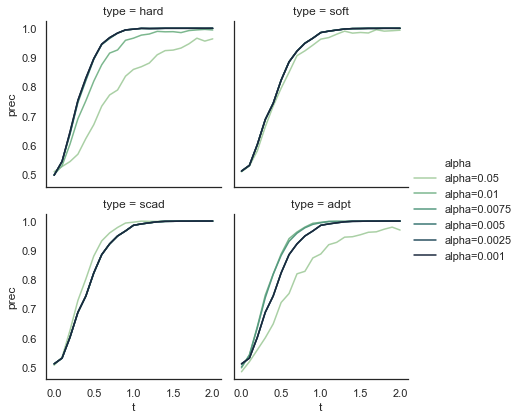

In [205]:
sns.set(style="white")
sns.relplot(x="Distance", y="Accuracy",
            hue="alpha",
            col='type',col_wrap=2,height=3,
            palette="ch:r=-.5,l=.75",kind='line',
            data=datas,ci=None)

In [84]:
data_method=data[(data.method!='LDAS')]
data_method.head()

,ytrue,ypred,method,alf,Type,Distance,Accuracy
480,0,0,LDA,-1.0,NaN,0.0,True
481,1,1,LDA,-1.0,NaN,0.0,True
482,0,1,LDA,-1.0,NaN,0.0,False
483,1,0,LDA,-1.0,NaN,0.0,False
484,0,1,LDA,-1.0,NaN,0.0,False


In [85]:
data_LDAS=datas.query("Type == 'hard'& alf == 0.001")
data_LDAS.head()

,ytrue,ypred,method,alf,Type,Distance,Accuracy
400,0,0,LDAS,0.001,hard,0.0,True
401,1,1,LDAS,0.001,hard,0.0,True
402,0,1,LDAS,0.001,hard,0.0,False
403,1,1,LDAS,0.001,hard,0.0,True
404,0,1,LDAS,0.001,hard,0.0,False


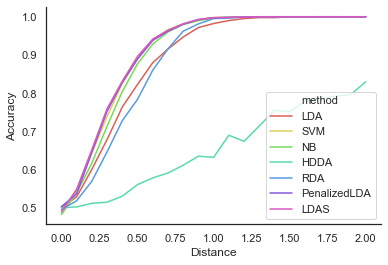

In [90]:
sns_plot=sns.lineplot(x="Distance", y="Accuracy", 
                      hue='method',
                      palette=sns.color_palette("hls", 7),
                      data=data_method.append(data_LDAS),ci=None)
sns.despine()

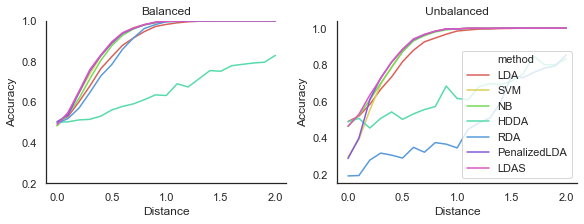

In [107]:
fig3 = plt.figure(constrained_layout=True,figsize=[8,3])
gs = fig3.add_gridspec(1, 2)
f3_ax1 = fig3.add_subplot(gs[0,0])
sns_plot=sns.lineplot(x="Distance", y="Accuracy", 
                      hue='method',
                      palette=sns.color_palette("hls", 7),
                      data=data_method.append(data_LDAS),ci=None,legend=None).set_title('Balanced')
plt.ylim(0.2, 1.0)
sns.despine()
f3_ax1 = fig3.add_subplot(gs[0,1])
data2=pd.read_csv('simulation/simulation_arm_unbalance.csv')
data2=data2.rename({'t': 'Distance', 'prec': 'Accuracy','type':'Type'}, axis='columns')
data_method2=data2[(data2.method!='LDAS')]
data_LDAS2=data2.query("method=='LDAS'").query("Type == 'hard'& alf == 0.001")

sns_plot=sns.lineplot(x="Distance", y="Accuracy", 
                      hue='method',
                      palette=sns.color_palette("hls", 7),
                      data=data_method2.append(data_LDAS2).query('ytrue==0'),ci=None).set_title('Unbalanced')
sns.despine()

In [108]:
fig = sns_plot.get_figure()
fig.savefig('method.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [265]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

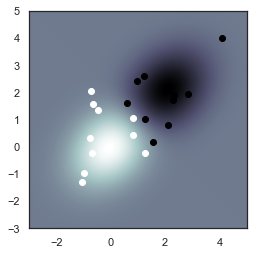

In [301]:
delta = 0.025
x = y = np.arange(-3.0, 5.0, delta)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv1 = multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]])
Z1 = rv1.pdf(pos)
rv2 = multivariate_normal([2, 2], [[1, 0.3], [0.3, 1]])
Z2 = rv2.pdf(pos)
Z = (Z1 - Z2)
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.bone,
               origin='lower', extent=[-3, 5, -3, 5],
               vmax=abs(Z).max(), vmin=-abs(Z).max())
mean, cov = [0, 0], [(1, .3), (.3, 1)]
data1 = np.random.multivariate_normal(mean, cov, 10)
df1 = pd.DataFrame(data1, columns=["x", "y"])
im = plt.scatter(df1.x, df1.y, color='white')
data2 = np.random.multivariate_normal(mean, cov, 10)
df2 = pd.DataFrame(data2+2, columns=["x", "y"])
im = plt.scatter(df2.x, df2.y, color='black')
plt.show()

In [306]:
fig.savefig('datagen.png', format='png', dpi=100)
fig.savefig('datagen.eps', format='eps', dpi=100)

In [109]:
MP=pd.read_csv('real/MP.csv')
MP_CV=pd.read_csv('real/MP_CV.csv')

In [112]:
MP_CV.head()

,index,fold
0,7,1
1,3,2
2,2,3
3,39,4
4,27,5


In [118]:
MPdata=pd.merge(MP, MP_CV, on=['index', 'index'])
MPdata['Accuracy']=MPdata.ytrue==MPdata.ypred

In [126]:
MPmethod=MPdata.query("method!='LDAS'")
MPldas=MPdata.query("method=='LDAS'")
CV_method=MPmethod.groupby(['method','fold'],as_index=False).mean()
CV_ldas=MPldas.groupby(['alf','type','fold'],as_index=False).mean()

(0.0, 1.05)

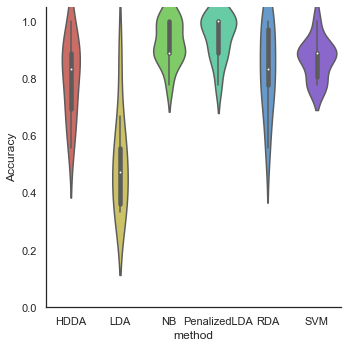

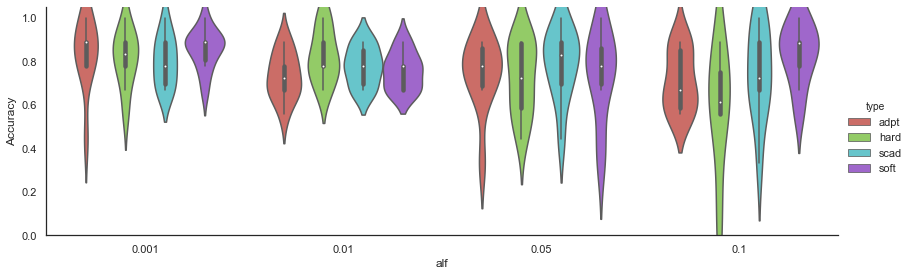

In [164]:
sns_plot=sns.catplot(x='method',y='Accuracy',data=CV_method,
           palette=sns.color_palette("hls", 7)[:-1],
           kind='violin')
plt.ylim(0.0,1.05)
sns_plot = sns.catplot(x='alf',y='Accuracy',hue="type",data=CV_ldas,
           palette=sns.color_palette("hls", 4),
           kind='violin',
           height=4, aspect=3)
plt.ylim(0.0,1.05)